# Notebook **Three** - How do candidate BCG spectroscopic redshifts compare to the original cluster redshifts?

This notebook contains everything necessary for you to work on the third step of this project - 
 
**Galaxy clusters** are single, gravitationally bound, objects made up of a **lot** of dark matter, quite a lot of hot gas (which is what emits X-rays), and the galaxies themselves (there are other components, but they don't matter right now).

**A BCG** is the most massive, brightest, galaxy in a cluster (though there can be multiple BCGs, or no obvious BCG at all).


**What questions are we asking at this stage of the project?**

1. How do the original redshifts for the cluster sample we're investigating compare to the spectroscopic redshifts of the BCG candidates?
2. In cases where BCG candidates have multiple identified spectra, do the different spectroscopic redshift measurements agree? 

## Import statements and reading history/sample

In [1]:
from ident_run_setup import cosmo, side_length, HISTORY_FILE_PATH, load_history, proj_name, update_history

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)

%matplotlib inline

The framework I've designed for this process (i.e. these notebooks) is trying to keep a useful history of the process - it has recorded the images that we were able to download or generate, and the BCG candidates you identified - here it will be keeping a record of the spectra you think are associated with each BCG candidate.

**This step will NOT produce an output csv file, as it isn't really a good format to store these results in (each BCG candidate can have multiple spectra, which doesn't really work in the 2D data storage of a csv) - as such to backup these results you should download the 'bcg_ident_proj_save.json' file, which is in the history directory.** 

In [2]:
cur_history = load_history()

Made a mistake in an earlier version of the spectral identification class, and the 6dF observation spectrum ID was just called 'spec_id' in the history, which clashes with some other headers when I'm constructing the multi-index dataframe below:

In [3]:
spec_ident = str(cur_history['bcg_spec_identification'])
if "'survey_spec_id': {'spec_id'" in spec_ident:
    spec_ident = spec_ident.replace("'survey_spec_id': {'spec_id'", "'survey_spec_id': {'obs_spec_id'")
    spec_ident = eval(spec_ident)
    cur_history['bcg_spec_identification'] = spec_ident
    update_history(cur_history)

We read the base **galaxy cluster** sample file into a Pandas dataframe - this contains the **original** redshifts for these clusters, which were derived from _photometric_ redshifts of member galaxies (so they aren't as accurate or reliable as the redshifts derived from the spectra you've identified):

In [4]:
# This reads the 'comma separated variable', or CSV/csv, file (which contains information about the sample of clusters
#  being investigated), from disk (on the hard-disk drive\HDD, or solid state disk\SSD) into memory (a much faster form of storage 
#  called Random Access Memory\RAM, where files being used by the operating system or currently running software live). We are using 
#  a Python module called 'Pandas' to read it in - think of it almost like a Python version of Excel
samp = pd.read_csv(cur_history['static_samp_file'])
# This means we can use .loc[ENTER NAME HERE] to get the information for a particular cluster
samp = samp.set_index('name')

# This method shows the top two lines of the loaded-in sample file
samp.head(2)

,LoVoCCSID,common_name,cent_im_ra,cent_im_dec,redshift,MCXC_R500,MCXC_RA,MCXC_DEC,manual_xray_ra,manual_xray_dec,MCXC_Lx500_0.1_2.4,ang_prop_ratio
name,,,,,,,,,,,,
LoVoCCS-1,1,A2029,227.7343,5.745471,0.0766,1.3344,227.73,5.72,227.7343,5.745471,8.726709e+44,86.035164
LoVoCCS-2,2,A401,44.7400,13.580000,0.0739,1.2421,44.74,13.58,NaN,NaN,6.088643e+44,83.258258


## Putting the spectroscopic redshifts into a Pandas dataframe

Here we are taking the information on the BCG candidate spectra that you identified in the last step (which have been stored in the project history file), and putting it into an easier-to-interact with form - a Pandas dataframe.

Pandas is a Python module that you may have come across before (though don't be worried if you haven't), and is **extremely** popular in data-science (and science science). The main feature of Pandas is its 'dataframes', which you can think of as being similar to an Excel spreadsheet, but in Python - they are a great way of organising information that can be stored in a table, and can even read in files of a variety of common types (in the section above I use Pandas to read in a 'csv').

You don't have to read in an existing file to make a dataframe though, you can construct one in Python from (for instance) a numpy array, and a list of column names. 

Here I am building a dataframe from the project history, which is a big nested dictionary (a standard Python data structure) - this is a fairly complicated process, and isn't something a beginner would start with, so I'm not going to explain it properly here. **Just know that the Pandas dataframe I produce here is different from 'standard' dataframes, because it is 'multi-indexed' - this means that rather than being a simple table with one set of column names, the column names can have their own sub-columns (so the column 'BCG1' might have 'spec0', 'spec1', etc. sub-columns, because you identified several associated spectra).**

In [5]:
bcg_spec_rejig = [{'name': clust_name} | spec_info for clust_name, spec_info in cur_history['bcg_spec_identification'].items()]
spec_info = pd.json_normalize(bcg_spec_rejig)

rel_cols = spec_info.columns[(spec_info.columns == 'name') | spec_info.columns.str.contains(r'\.spec_id|z') | 
                              spec_info.columns.str.endswith('survey')]
spec_info = spec_info[rel_cols]
spec_info = spec_info.set_index('name')

spec_info.columns = pd.MultiIndex.from_tuples([tuple(col.split(".")) for col in spec_info.columns])
spec_info = spec_info.droplevel(1, axis=1)
spec_info.sort_index(axis=1, inplace=True)

## <span style="color:green">**YOU'RE FREE TO CHANGE EVERYTHING AFTER THIS!**</span>

## How can you access information from the dataframe?

The variable you need to use is 'spec_info' - if you type it in a Jupyter Notebook cell and run it (cmd+return on a Macbook), you'll be able to have a look at it. 

I've done just that in the cell below this one, and if you scroll the table to the right you should be able to see what I mean about each column having sub-columns (and even the sub-columns have sub-columns in this setup) - again this is **not** what a 'normal' (whatever that means) dataframe is like, they tend to just have one set of column names.

In [6]:
spec_info

BCG1                                                         \
                 spec0                                           spec1          
               spec_id survey         z     z_err z_quality    spec_id survey   
name                                                                            
LoVoCCS-1    4634042.0    cfa  0.073284  0.000667       NaN  4634043.0    cfa   
LoVoCCS-2          NaN    NaN       NaN       NaN       NaN        NaN    NaN   
LoVoCCS-4A    231472.0   sdss  0.055359  0.000016       NaN  4605303.0    cfa   
LoVoCCS-4B   4605284.0    cfa  0.056326  0.000117       NaN  5683825.0   fast   
LoVoCCS-5    4639181.0    cfa  0.055378  0.000147       NaN        NaN    NaN   
...                ...    ...       ...       ...       ...        ...    ...   
LoVoCCS-121  4612420.0    cfa  0.063944  0.000334       NaN        NaN    NaN   
LoVoCCS-122        NaN    NaN       NaN       NaN       NaN        NaN    NaN   
LoVoCCS-123        NaN    NaN       NaN       NaN       NaN        NaN    NaN   
LoVoCCS-131        NaN    NaN       NaN       NaN       NaN        NaN    NaN   
LoVoCCS-134        NaN    NaN       NaN       NaN       NaN        NaN    NaN   

                                                                           \
                                               spec2                        
                    z     z_err z_quality    spec_id     survey         z   
name                                                                        
LoVoCCS-1    0.077997  0.000334       NaN  4712886.0  hectospec  0.073512   
LoVoCCS-2         NaN       NaN       NaN        NaN        NaN       NaN   
LoVoCCS-4A   0.055158  0.000147       NaN  5673213.0       fast  0.055488   
LoVoCCS-4B   0.056123       NaN       NaN  5686980.0       fast  0.056031   
LoVoCCS-5         NaN       NaN       NaN        NaN        NaN       NaN   
...               ...       ...       ...        ...        ...       ...   
LoVoCCS-121       NaN       NaN       NaN        NaN        NaN       NaN   
LoVoCCS-122       NaN       NaN       NaN        NaN        NaN       NaN   
LoVoCCS-123       NaN       NaN       NaN        NaN        NaN       NaN   
LoVoCCS-131       NaN       NaN       NaN        NaN        NaN       NaN   
LoVoCCS-134       NaN       NaN       NaN        NaN        NaN       NaN   

                                                                         \
                                 spec3                                    
            z_err z_quality    spec_id survey         z z_err z_quality   
name                                                                      
LoVoCCS-1     NaN       NaN  5678635.0   fast  0.078171   NaN       NaN   
LoVoCCS-2     NaN       NaN        NaN    NaN       NaN   NaN       NaN   
LoVoCCS-4A    NaN       NaN  5673270.0   fast  0.330414   NaN       NaN   
LoVoCCS-4B    NaN       NaN        NaN    NaN       NaN   NaN       NaN   
LoVoCCS-5     NaN       NaN        NaN    NaN       NaN   NaN       NaN   
...           ...       ...        ...    ...       ...   ...       ...   
LoVoCCS-121   NaN       NaN        NaN    NaN       NaN   NaN       NaN   
LoVoCCS-122   NaN       NaN        NaN    NaN       NaN   NaN       NaN   
LoVoCCS-123   NaN       NaN        NaN    NaN       NaN   NaN       NaN   
LoVoCCS-131   NaN       NaN        NaN    NaN       NaN   NaN       NaN   
LoVoCCS-134   NaN       NaN        NaN    NaN       NaN   NaN       NaN   

                                                                           \
                 spec4                                       spec5          
               spec_id survey         z z_err z_quality    spec_id survey   
name                                                                        
LoVoCCS-1          NaN    NaN       NaN   NaN       NaN        NaN    NaN   
LoVoCCS-2          NaN    NaN       NaN   NaN       NaN        NaN    NaN   
LoVoCCS-4A   5673330.0   fast  0.055128   NaN       NaN  5

### Accessing data for specific clusters

Depending on how successful the spectrum identification process was, or if you started using the spectrum identification tool part way through the sample, you might see a lot of columns that just have 'NaN' in them - this stands for 'not a number', and is used throughout Pandas (and many other modules) as a 'null value'. Basically it indicates there is no information there. In other circumstances it might represent the result of a calculation that has no defined value (dividing something by zero for instance).

So, lets take a look at a cluster for which you know you identified some spectra (you're going to have change this yourself) - the way I set up this dataframe, you're going to be able to specify the **row** you're interested in by giving it the name of the cluster. **This won't be true of all dataframes, a lot of time you would need to specify the row number (also important to note is that Python uses 'zero-based' indexing, which means it starts counting at 0, so if you were using row numbers, the first row is row zero**).

We pass the name of the cluster to '.loc', which is for 'indexing' based on **labels** (e.g. rows with names rather than numbers, which is what I set up):

In [7]:
spec_info.loc['LoVoCCS-1']

BCG1  spec0  spec_id      4634042.0
             survey             cfa
             z             0.073284
             z_err         0.000667
             z_quality          NaN
                            ...    
BCG4  spec1  z_quality          NaN
      spec2  spec_id            NaN
             survey             NaN
             z                  NaN
             z_err              NaN
Name: LoVoCCS-1, Length: 93, dtype: object

Now you can see (if you have chosen a cluster that you **did** identify spectra for), that not everything is NaN! Bear in mind that you might not see _every_ column for the row you specified, as Pandas restricts how many it can show to avoid printing too much to the screen - you can tell if it has truncated what it is showing you by looking for the '...' ellipsis. 

What if we wanted to access more than one cluster (i.e. more than one row)? You use the same sort of command, but pass a list of cluster names:

In [8]:
spec_info.loc[['LoVoCCS-1', 'LoVoCCS-13']]

BCG1                                                         \
                spec0                                           spec1          
              spec_id survey         z     z_err z_quality    spec_id survey   
name                                                                           
LoVoCCS-1   4634042.0    cfa  0.073284  0.000667       NaN  4634043.0    cfa   
LoVoCCS-13  4611961.0    cfa  0.075752  0.000233       NaN        NaN    NaN   

                                                                          \
                                              spec2                        
                   z     z_err z_quality    spec_id     survey         z   
name                                                                       
LoVoCCS-1   0.077997  0.000334       NaN  4712886.0  hectospec  0.073512   
LoVoCCS-13       NaN       NaN       NaN        NaN        NaN       NaN   

                                                                        \
                                spec3                                    
           z_err z_quality    spec_id survey         z z_err z_quality   
name                                                                     
LoVoCCS-1    NaN       NaN  5678635.0   fast  0.078171   NaN       NaN   
LoVoCCS-13   NaN       NaN        NaN    NaN       NaN   NaN       NaN   

                                                                        \
             spec4                              spec5                    
           spec_id survey   z z_err z_quality spec_id survey   z z_err   
name                                                                     
LoVoCCS-1      NaN    NaN NaN   NaN       NaN     NaN    NaN NaN   NaN   
LoVoCCS-13     NaN    NaN NaN   NaN       NaN     NaN    NaN NaN   NaN   

                                                                            \
                       spec6                              spec7              
           z_quality spec_id survey   z z_err z_quality spec_id survey   z   
name                                                                         
LoVoCCS-1        NaN     NaN    NaN NaN   NaN       NaN     NaN    NaN NaN   
LoVoCCS-13       NaN     NaN    NaN NaN   NaN       NaN     NaN    NaN NaN   

                                                                              \
                             spec8                              spec9          
           z_err z_quality spec_id survey   z z_err z_quality spec_id survey   
name                                                                           
LoVoCCS-1    NaN       NaN     NaN    NaN NaN   NaN       NaN     NaN    NaN   
LoVoCCS-13   NaN       NaN     NaN    NaN NaN   NaN       NaN     NaN    NaN   

                                  BCG2                                     \
                                 spec0                              spec1   
             z z_err z_quality spec_id survey   z z_err z_quality spec_id   
name                                                                        
LoVoCCS-1  NaN   NaN       NaN     NaN    NaN NaN   NaN       NaN     NaN   
LoVoCCS-13 NaN   NaN       NaN     NaN    NaN NaN   NaN       NaN     NaN   

                                                                          \
                                        spec2                              
           survey   z z_err z_quality spec_id survey   z z_err z_quality   
name                                                                       
LoVoCCS-1     NaN NaN   NaN       NaN     NaN    NaN NaN   NaN       NaN   
LoVoCCS-13    NaN NaN   NaN       NaN     NaN    NaN NaN   NaN       NaN   

                                       BCG3                             \
             spec3                    spec0                              
           spec_id survey   z z_err spec_id survey   z z_err z_quality   
name                                                                     
LoVoCCS-1      NaN    N

### Accessing data for all clusters from specific columns

Accessing data for specific rows is very useful in many circumstances, but a lot of the time we want to do something with particular properties or pieces of information for **every** row in the table - in those cases it might be useful to be able to access, for instance, every redshift measured for every 'BCG1', without having to go through each cluster one by one.

This operation is almost the inverse of accessing data for specific rows, and the syntax we use is nearly identical. Lets start with the simplest case - you want to get all the information for the 'BCG1' column (**and note that we don't have to use 'loc' for this simple case, as the dataframe assumes that indexes passed like this are column names, rather than the name of a row**):

In [9]:
spec_info['BCG1']

spec0                                           spec1         \
               spec_id survey         z     z_err z_quality    spec_id survey   
name                                                                            
LoVoCCS-1    4634042.0    cfa  0.073284  0.000667       NaN  4634043.0    cfa   
LoVoCCS-2          NaN    NaN       NaN       NaN       NaN        NaN    NaN   
LoVoCCS-4A    231472.0   sdss  0.055359  0.000016       NaN  4605303.0    cfa   
LoVoCCS-4B   4605284.0    cfa  0.056326  0.000117       NaN  5683825.0   fast   
LoVoCCS-5    4639181.0    cfa  0.055378  0.000147       NaN        NaN    NaN   
...                ...    ...       ...       ...       ...        ...    ...   
LoVoCCS-121  4612420.0    cfa  0.063944  0.000334       NaN        NaN    NaN   
LoVoCCS-122        NaN    NaN       NaN       NaN       NaN        NaN    NaN   
LoVoCCS-123        NaN    NaN       NaN       NaN       NaN        NaN    NaN   
LoVoCCS-131        NaN    NaN       NaN       NaN       NaN        NaN    NaN   
LoVoCCS-134        NaN    NaN       NaN       NaN       NaN        NaN    NaN   

                                               spec2                       \
                    z     z_err z_quality    spec_id     survey         z   
name                                                                        
LoVoCCS-1    0.077997  0.000334       NaN  4712886.0  hectospec  0.073512   
LoVoCCS-2         NaN       NaN       NaN        NaN        NaN       NaN   
LoVoCCS-4A   0.055158  0.000147       NaN  5673213.0       fast  0.055488   
LoVoCCS-4B   0.056123       NaN       NaN  5686980.0       fast  0.056031   
LoVoCCS-5         NaN       NaN       NaN        NaN        NaN       NaN   
...               ...       ...       ...        ...        ...       ...   
LoVoCCS-121       NaN       NaN       NaN        NaN        NaN       NaN   
LoVoCCS-122       NaN       NaN       NaN        NaN        NaN       NaN   
LoVoCCS-123       NaN       NaN       NaN        NaN        NaN       NaN   
LoVoCCS-131       NaN       NaN       NaN        NaN        NaN       NaN   
LoVoCCS-134       NaN       NaN       NaN        NaN        NaN       NaN   

                                 spec3                                   \
            z_err z_quality    spec_id survey         z z_err z_quality   
name                                                                      
LoVoCCS-1     NaN       NaN  5678635.0   fast  0.078171   NaN       NaN   
LoVoCCS-2     NaN       NaN        NaN    NaN       NaN   NaN       NaN   
LoVoCCS-4A    NaN       NaN  5673270.0   fast  0.330414   NaN       NaN   
LoVoCCS-4B    NaN       NaN        NaN    NaN       NaN   NaN       NaN   
LoVoCCS-5     NaN       NaN        NaN    NaN       NaN   NaN       NaN   
...           ...       ...        ...    ...       ...   ...       ...   
LoVoCCS-121   NaN       NaN        NaN    NaN       NaN   NaN       NaN   
LoVoCCS-122   NaN       NaN        NaN    NaN       NaN   NaN       NaN   
LoVoCCS-123   NaN       NaN        NaN    NaN       NaN   NaN       NaN   
LoVoCCS-131   NaN       NaN        NaN    NaN       NaN   NaN       NaN   
LoVoCCS-134   NaN       NaN        NaN    NaN       NaN   NaN       NaN   

                 spec4                                       spec5         \
               spec_id survey         z z_err z_quality    spec_id survey   
name                                                                        
LoVoCCS-1          NaN    NaN       NaN   NaN       NaN        NaN    NaN   
LoVoCCS-2          NaN    NaN       NaN   NaN       NaN        NaN    NaN   
LoVoCCS-4A   5673330.0   fast  0.055128   NaN       NaN  5673367.0   fast   
LoVoCCS-4B         NaN    NaN       NaN   NaN       NaN        NaN    NaN   
LoVoCCS-5          NaN    NaN       NaN   NaN       NaN        NaN    NaN   
...                ...    ...       ...   ...       ...        ...    ...   
LoVoCCS-121        NaN    NaN       NaN   NaN       NaN    

If you compare what you see above to the table output at the beginning of the 'How can you access information from the dataframe?' section of this notebook, you should see that there is one fewer 'level' in the column names. The output we just produced doesn't have top-level column names of 'BCG1', 'BCG2', etc., as we have just selected **only** the 'BCG1' top-level column.

What if you wanted just the information about the first spectrum assigned to the BCG candidate? - _Also I realise the BCG numbering starts at one, and the spectrum numbering starts at zero - that was my mistake when designing this._ - Well, **we can just add another column name to our column indexing**:

In [10]:
spec_info['BCG1']['spec0']

,spec_id,survey,z,z_err,z_quality
name,,,,,
LoVoCCS-1,4634042.0,cfa,0.073284,0.000667,NaN
LoVoCCS-2,NaN,NaN,NaN,NaN,NaN
LoVoCCS-4A,231472.0,sdss,0.055359,0.000016,NaN
LoVoCCS-4B,4605284.0,cfa,0.056326,0.000117,NaN
LoVoCCS-5,4639181.0,cfa,0.055378,0.000147,NaN
...,...,...,...,...,...
LoVoCCS-121,4612420.0,cfa,0.063944,0.000334,NaN
LoVoCCS-122,NaN,NaN,NaN,NaN,NaN
LoVoCCS-123,NaN,NaN,NaN,NaN,NaN


**And so on:**

In [11]:
spec_info['BCG1']['spec0']['z']

name
LoVoCCS-1      0.073284
LoVoCCS-2           NaN
LoVoCCS-4A     0.055359
LoVoCCS-4B     0.056326
LoVoCCS-5      0.055378
                 ...   
LoVoCCS-121    0.063944
LoVoCCS-122         NaN
LoVoCCS-123         NaN
LoVoCCS-131         NaN
LoVoCCS-134         NaN
Name: z, Length: 67, dtype: float64

However, we once again find ourselves focused in on a really specific set of values - except this time rather than being focused on one or two clusters/rows, we've focused on one measurement of redshift, specifically for the first spectrum associated with the first BCG candidate of a cluster. 

**What if we want to go a bit wider with our information? Say we wanted to compare the redshifts of the first spectrum associated with _each_ BCG candidate, to the existing redshifts of the input cluster sample (remember one of the reasons you've found all these spectra are to try and improve the existing redshifts of our clusters)!**

Well, we can use the same style of indexing the different levels of columns, but we avoid specifying the exact BCG candidate column - **instead we will give it ':', which just means 'all columns' in this context - because of where we pass ':', it really means _all top-level columns_**:

In [12]:
spec_info[:]['spec0']['z']

,z,z,z,z
name,,,,
LoVoCCS-1,0.073284,NaN,NaN,NaN
LoVoCCS-2,NaN,NaN,NaN,NaN
LoVoCCS-4A,0.055359,NaN,NaN,NaN
LoVoCCS-4B,0.056326,NaN,NaN,NaN
LoVoCCS-5,0.055378,0.056339,0.057523,0.052369
...,...,...,...,...
LoVoCCS-121,0.063944,NaN,NaN,NaN
LoVoCCS-122,NaN,NaN,NaN,NaN
LoVoCCS-123,NaN,NaN,NaN,NaN


This way of accessing data can **be used at any 'level'** - so if what we really wanted was **all** the spectroscopic redshifts measured for each all the 'BCG1' candidates (for instance maybe we want to compare them to validate the selected spectra, as if all spectra selected for a particular galaxy really are of that galaxy, the redshifts should agree) then we could do this: 

In [13]:
spec_info['BCG1'][:]['z']

,z,z,z,z,z,z,z,z,z,z
name,,,,,,,,,,
LoVoCCS-1,0.073284,0.077997,0.073512,0.078171,NaN,NaN,NaN,NaN,NaN,NaN
LoVoCCS-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LoVoCCS-4A,0.055359,0.055158,0.055488,0.330414,0.055128,0.327754,0.328707,0.095876,0.055441,0.055589
LoVoCCS-4B,0.056326,0.056123,0.056031,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LoVoCCS-5,0.055378,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
LoVoCCS-121,0.063944,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LoVoCCS-122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LoVoCCS-123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### A more sophisticated way of accessing data for all clusters from specific columns

One final note, the syntax I've been showing you above is very useful, but does have its limits. If you tried (for instance) to get every 'z' column value for every spectra of every BCG candidate, while using the syntax I've been showing you, you would get an error. 

You should now try and access every 'z' value for every spectra of every BCG candidate below here, using the syntax you've been reading about - this should give you a 'KeyError':

In [14]:
# spec_info

Now that you've tried that, and hopefully have seen that it doesn't work, we will figure out how to do it properly.

The issue we're having is that, by 'chaining' the column selections in separate square brackets like that, we are actually whittling down the dataframe **one column level at a time**, rather than doing it all at once. Don't worry if you don't get why that is a problem, because it is a subtle distinction, but essentially what is happening is this - the first selection executes, and we get back a dataframe that has every 'specN' column, for **every** BCG candidate (i.e. BCG1, BCG2, etc.) - so far so good:

In [15]:
all_bcgs = spec_info[:]
all_bcgs

spec0                                           spec1         \
               spec_id survey         z     z_err z_quality    spec_id survey   
name                                                                            
LoVoCCS-1    4634042.0    cfa  0.073284  0.000667       NaN  4634043.0    cfa   
LoVoCCS-2          NaN    NaN       NaN       NaN       NaN        NaN    NaN   
LoVoCCS-4A    231472.0   sdss  0.055359  0.000016       NaN  4605303.0    cfa   
LoVoCCS-4B   4605284.0    cfa  0.056326  0.000117       NaN  5683825.0   fast   
LoVoCCS-5    4639181.0    cfa  0.055378  0.000147       NaN        NaN    NaN   
...                ...    ...       ...       ...       ...        ...    ...   
LoVoCCS-121  4612420.0    cfa  0.063944  0.000334       NaN        NaN    NaN   
LoVoCCS-122        NaN    NaN       NaN       NaN       NaN        NaN    NaN   
LoVoCCS-123        NaN    NaN       NaN       NaN       NaN        NaN    NaN   
LoVoCCS-131        NaN    NaN       NaN       NaN       NaN        NaN    NaN   
LoVoCCS-134        NaN    NaN       NaN       NaN       NaN        NaN    NaN   

                                               spec2                       \
                    z     z_err z_quality    spec_id     survey         z   
name                                                                        
LoVoCCS-1    0.077997  0.000334       NaN  4712886.0  hectospec  0.073512   
LoVoCCS-2         NaN       NaN       NaN        NaN        NaN       NaN   
LoVoCCS-4A   0.055158  0.000147       NaN  5673213.0       fast  0.055488   
LoVoCCS-4B   0.056123       NaN       NaN  5686980.0       fast  0.056031   
LoVoCCS-5         NaN       NaN       NaN        NaN        NaN       NaN   
...               ...       ...       ...        ...        ...       ...   
LoVoCCS-121       NaN       NaN       NaN        NaN        NaN       NaN   
LoVoCCS-122       NaN       NaN       NaN        NaN        NaN       NaN   
LoVoCCS-123       NaN       NaN       NaN        NaN        NaN       NaN   
LoVoCCS-131       NaN       NaN       NaN        NaN        NaN       NaN   
LoVoCCS-134       NaN       NaN       NaN        NaN        NaN       NaN   

                                 spec3                                   \
            z_err z_quality    spec_id survey         z z_err z_quality   
name                                                                      
LoVoCCS-1     NaN       NaN  5678635.0   fast  0.078171   NaN       NaN   
LoVoCCS-2     NaN       NaN        NaN    NaN       NaN   NaN       NaN   
LoVoCCS-4A    NaN       NaN  5673270.0   fast  0.330414   NaN       NaN   
LoVoCCS-4B    NaN       NaN        NaN    NaN       NaN   NaN       NaN   
LoVoCCS-5     NaN       NaN        NaN    NaN       NaN   NaN       NaN   
...           ...       ...        ...    ...       ...   ...       ...   
LoVoCCS-121   NaN       NaN        NaN    NaN       NaN   NaN       NaN   
LoVoCCS-122   NaN       NaN        NaN    NaN       NaN   NaN       NaN   
LoVoCCS-123   NaN       NaN        NaN    NaN       NaN   NaN       NaN   
LoVoCCS-131   NaN       NaN        NaN    NaN       NaN   NaN       NaN   
LoVoCCS-134   NaN       NaN        NaN    NaN       NaN   NaN       NaN   

                 spec4                                       spec5         \
               spec_id survey         z z_err z_quality    spec_id survey   
name                                                                        
LoVoCCS-1          NaN    NaN       NaN   NaN       NaN        NaN    NaN   
LoVoCCS-2          NaN    NaN       NaN   NaN       NaN        NaN    NaN   
LoVoCCS-4A   5673330.0   fast  0.055128   NaN       NaN  5673367.0   fast   
LoVoCCS-4B         NaN    NaN       NaN   NaN       NaN        NaN    NaN   
LoVoCCS-5          NaN    NaN       NaN   NaN       NaN        NaN    NaN   
...                ...    ...       ...   ...       ...        ...    ...   
LoVoCCS-121        NaN    NaN       NaN   NaN       NaN    

**However, now we try to apply the next selection, which in this case is using all the spec0, spec1, etc. columns, and nothing changes in our dataframe (compare it to the above dataframe)**:

In [16]:
all_sp_all_bcgs = all_bcgs[:]
all_sp_all_bcgs

spec0                                           spec1         \
               spec_id survey         z     z_err z_quality    spec_id survey   
name                                                                            
LoVoCCS-1    4634042.0    cfa  0.073284  0.000667       NaN  4634043.0    cfa   
LoVoCCS-2          NaN    NaN       NaN       NaN       NaN        NaN    NaN   
LoVoCCS-4A    231472.0   sdss  0.055359  0.000016       NaN  4605303.0    cfa   
LoVoCCS-4B   4605284.0    cfa  0.056326  0.000117       NaN  5683825.0   fast   
LoVoCCS-5    4639181.0    cfa  0.055378  0.000147       NaN        NaN    NaN   
...                ...    ...       ...       ...       ...        ...    ...   
LoVoCCS-121  4612420.0    cfa  0.063944  0.000334       NaN        NaN    NaN   
LoVoCCS-122        NaN    NaN       NaN       NaN       NaN        NaN    NaN   
LoVoCCS-123        NaN    NaN       NaN       NaN       NaN        NaN    NaN   
LoVoCCS-131        NaN    NaN       NaN       NaN       NaN        NaN    NaN   
LoVoCCS-134        NaN    NaN       NaN       NaN       NaN        NaN    NaN   

                                               spec2                       \
                    z     z_err z_quality    spec_id     survey         z   
name                                                                        
LoVoCCS-1    0.077997  0.000334       NaN  4712886.0  hectospec  0.073512   
LoVoCCS-2         NaN       NaN       NaN        NaN        NaN       NaN   
LoVoCCS-4A   0.055158  0.000147       NaN  5673213.0       fast  0.055488   
LoVoCCS-4B   0.056123       NaN       NaN  5686980.0       fast  0.056031   
LoVoCCS-5         NaN       NaN       NaN        NaN        NaN       NaN   
...               ...       ...       ...        ...        ...       ...   
LoVoCCS-121       NaN       NaN       NaN        NaN        NaN       NaN   
LoVoCCS-122       NaN       NaN       NaN        NaN        NaN       NaN   
LoVoCCS-123       NaN       NaN       NaN        NaN        NaN       NaN   
LoVoCCS-131       NaN       NaN       NaN        NaN        NaN       NaN   
LoVoCCS-134       NaN       NaN       NaN        NaN        NaN       NaN   

                                 spec3                                   \
            z_err z_quality    spec_id survey         z z_err z_quality   
name                                                                      
LoVoCCS-1     NaN       NaN  5678635.0   fast  0.078171   NaN       NaN   
LoVoCCS-2     NaN       NaN        NaN    NaN       NaN   NaN       NaN   
LoVoCCS-4A    NaN       NaN  5673270.0   fast  0.330414   NaN       NaN   
LoVoCCS-4B    NaN       NaN        NaN    NaN       NaN   NaN       NaN   
LoVoCCS-5     NaN       NaN        NaN    NaN       NaN   NaN       NaN   
...           ...       ...        ...    ...       ...   ...       ...   
LoVoCCS-121   NaN       NaN        NaN    NaN       NaN   NaN       NaN   
LoVoCCS-122   NaN       NaN        NaN    NaN       NaN   NaN       NaN   
LoVoCCS-123   NaN       NaN        NaN    NaN       NaN   NaN       NaN   
LoVoCCS-131   NaN       NaN        NaN    NaN       NaN   NaN       NaN   
LoVoCCS-134   NaN       NaN        NaN    NaN       NaN   NaN       NaN   

                 spec4                                       spec5         \
               spec_id survey         z z_err z_quality    spec_id survey   
name                                                                        
LoVoCCS-1          NaN    NaN       NaN   NaN       NaN        NaN    NaN   
LoVoCCS-2          NaN    NaN       NaN   NaN       NaN        NaN    NaN   
LoVoCCS-4A   5673330.0   fast  0.055128   NaN       NaN  5673367.0   fast   
LoVoCCS-4B         NaN    NaN       NaN   NaN       NaN        NaN    NaN   
LoVoCCS-5          NaN    NaN       NaN   NaN       NaN        NaN    NaN   
...                ...    ...       ...   ...       ...        ...    ...   
LoVoCCS-121        NaN    NaN       NaN   NaN       NaN    

That means that when we try to pass 'z' to select all redshifts, from all spectra, for all candidates, it will fail. This is because the **top level columns** of the dataframe produced by the second stage of filtering are **still spectrum identifiers (i.e. spec0, spec1, etc.)**.

If you wanted to filter the dataframe in this manner, getting all the redshifts, from all the spectra, for all the BCG candidates, we have to go back to using the '.loc' method (a 'method' in Python is a function that is part of a 'class' - if you don't know what classes are you can search for reading about object-oriented programming).

The difference between our last use of '.loc', when we were retrieving information for specific clusters (toward the top of this notebook), and how we use it now is very small - we just need to specify that we want to fetch columns, rather than rows. We do this by passing an `axis=1` value to the loc method (in brackets before the square brackets - those round brackets were not necessary when we used loc the first time). In Pandas (and Numpy) the '0' axis is the y axis of a dataframe or array, and the '1' axis is the x-axis.

Using .loc (with `axis=1`), we can impose our requirements of getting all redshifts, for all spectra, for all candidates, **at the same time** rather than sequentially, and we will get out a dataframe that has been filtered to **just contain redshift information**:

In [17]:
spec_info.loc(axis=1)[:, :, 'z']

BCG1                                                    \
                spec0     spec1     spec2     spec3     spec4     spec5   
                    z         z         z         z         z         z   
name                                                                      
LoVoCCS-1    0.073284  0.077997  0.073512  0.078171       NaN       NaN   
LoVoCCS-2         NaN       NaN       NaN       NaN       NaN       NaN   
LoVoCCS-4A   0.055359  0.055158  0.055488  0.330414  0.055128  0.327754   
LoVoCCS-4B   0.056326  0.056123  0.056031       NaN       NaN       NaN   
LoVoCCS-5    0.055378       NaN       NaN       NaN       NaN       NaN   
...               ...       ...       ...       ...       ...       ...   
LoVoCCS-121  0.063944       NaN       NaN       NaN       NaN       NaN   
LoVoCCS-122       NaN       NaN       NaN       NaN       NaN       NaN   
LoVoCCS-123       NaN       NaN       NaN       NaN       NaN       NaN   
LoVoCCS-131       NaN       NaN       NaN       NaN       NaN       NaN   
LoVoCCS-134       NaN       NaN       NaN       NaN       NaN       NaN   

                                                         BCG2              \
                spec6     spec7     spec8     spec9     spec0 spec1 spec2   
                    z         z         z         z         z     z     z   
name                                                                        
LoVoCCS-1         NaN       NaN       NaN       NaN       NaN   NaN   NaN   
LoVoCCS-2         NaN       NaN       NaN       NaN       NaN   NaN   NaN   
LoVoCCS-4A   0.328707  0.095876  0.055441  0.055589       NaN   NaN   NaN   
LoVoCCS-4B        NaN       NaN       NaN       NaN       NaN   NaN   NaN   
LoVoCCS-5         NaN       NaN       NaN       NaN  0.056339   NaN   NaN   
...               ...       ...       ...       ...       ...   ...   ...   
LoVoCCS-121       NaN       NaN       NaN       NaN       NaN   NaN   NaN   
LoVoCCS-122       NaN       NaN       NaN       NaN       NaN   NaN   NaN   
LoVoCCS-123       NaN       NaN       NaN       NaN       NaN   NaN   NaN   
LoVoCCS-131       NaN       NaN       NaN       NaN  0.090662   NaN   NaN   
LoVoCCS-134       NaN       NaN       NaN       NaN       NaN   NaN   NaN   

                       BCG3            BCG4                  
            spec3     spec0 spec1     spec0     spec1 spec2  
                z         z     z         z         z     z  
name                                                         
LoVoCCS-1     NaN       NaN   NaN       NaN       NaN   NaN  
LoVoCCS-2     NaN       NaN   NaN       NaN       NaN   NaN  
LoVoCCS-4A    NaN       NaN   NaN       NaN       NaN   NaN  
LoVoCCS-4B    NaN       NaN   NaN       NaN       NaN   NaN  
LoVoCCS-5     NaN  0.057523   NaN  0.052369  0.054171   NaN  
...           ...       ...   ...       ...       ...   ...  
LoVoCCS-121   NaN       NaN   NaN       NaN       NaN   NaN  
LoVoCCS-122   NaN       NaN   NaN       NaN       NaN   NaN  
LoVoCCS-123   NaN       NaN   NaN       NaN       NaN   NaN  
LoVoCCS-131   NaN       NaN   NaN       NaN       NaN   NaN  
LoVoCCS-134   NaN       NaN   NaN       NaN       NaN   NaN  

[67 rows x 19 columns]

We can also use this syntax to filter to include more-than-one column (it is the exact same logic as when we used .loc to retrieve more than one row earlier):

In [18]:
spec_info.loc(axis=1)[:, :, ['z', 'z_err']]

BCG1                                                          \
                spec0               spec1               spec2           spec3   
                    z     z_err         z     z_err         z z_err         z   
name                                                                            
LoVoCCS-1    0.073284  0.000667  0.077997  0.000334  0.073512   NaN  0.078171   
LoVoCCS-2         NaN       NaN       NaN       NaN       NaN   NaN       NaN   
LoVoCCS-4A   0.055359  0.000016  0.055158  0.000147  0.055488   NaN  0.330414   
LoVoCCS-4B   0.056326  0.000117  0.056123       NaN  0.056031   NaN       NaN   
LoVoCCS-5    0.055378  0.000147       NaN       NaN       NaN   NaN       NaN   
...               ...       ...       ...       ...       ...   ...       ...   
LoVoCCS-121  0.063944  0.000334       NaN       NaN       NaN   NaN       NaN   
LoVoCCS-122       NaN       NaN       NaN       NaN       NaN   NaN       NaN   
LoVoCCS-123       NaN       NaN       NaN       NaN       NaN   NaN       NaN   
LoVoCCS-131       NaN       NaN       NaN       NaN       NaN   NaN       NaN   
LoVoCCS-134       NaN       NaN       NaN       NaN       NaN   NaN       NaN   

                                                                             \
                      spec4           spec5           spec6           spec7   
            z_err         z z_err         z z_err         z z_err         z   
name                                                                          
LoVoCCS-1     NaN       NaN   NaN       NaN   NaN       NaN   NaN       NaN   
LoVoCCS-2     NaN       NaN   NaN       NaN   NaN       NaN   NaN       NaN   
LoVoCCS-4A    NaN  0.055128   NaN  0.327754   NaN  0.328707   NaN  0.095876   
LoVoCCS-4B    NaN       NaN   NaN       NaN   NaN       NaN   NaN       NaN   
LoVoCCS-5     NaN       NaN   NaN       NaN   NaN       NaN   NaN       NaN   
...           ...       ...   ...       ...   ...       ...   ...       ...   
LoVoCCS-121   NaN       NaN   NaN       NaN   NaN       NaN   NaN       NaN   
LoVoCCS-122   NaN       NaN   NaN       NaN   NaN       NaN   NaN       NaN   
LoVoCCS-123   NaN       NaN   NaN       NaN   NaN       NaN   NaN       NaN   
LoVoCCS-131   NaN       NaN   NaN       NaN   NaN       NaN   NaN       NaN   
LoVoCCS-134   NaN       NaN   NaN       NaN   NaN       NaN   NaN       NaN   

                                                       BCG2                  \
                      spec8           spec9           spec0           spec1   
            z_err         z z_err         z z_err         z     z_err     z   
name                                                                          
LoVoCCS-1     NaN       NaN   NaN       NaN   NaN       NaN       NaN   NaN   
LoVoCCS-2     NaN       NaN   NaN       NaN   NaN       NaN       NaN   NaN   
LoVoCCS-4A    NaN  0.055441   NaN  0.055589   NaN       NaN       NaN   NaN   
LoVoCCS-4B    NaN       NaN   NaN       NaN   NaN       NaN       NaN   NaN   
LoVoCCS-5     NaN       NaN   NaN       NaN   NaN  0.056339  0.000233   NaN   
...           ...       ...   ...       ...   ...       ...       ...   ...   
LoVoCCS-121   NaN       NaN   NaN       NaN   NaN       NaN       NaN   NaN   
LoVoCCS-122   NaN       NaN   NaN       NaN   NaN       NaN       NaN   NaN   
LoVoCCS-123   NaN       NaN   NaN       NaN   NaN       NaN       NaN   NaN   
LoVoCCS-131   NaN       NaN   NaN       NaN   NaN  0.090662       NaN   NaN   
LoVoCCS-134   NaN       NaN   NaN       NaN   NaN       NaN       NaN   NaN   

                                               BCG3                        \
                  spec2       spec3           spec0           spec1         
            z_err     z z_err     z z_err         z     z_err     z z_err   
name                                                                        
LoVoCCS-1     NaN   NaN   NaN   NaN   NaN       NaN       NaN   NaN   NaN   
LoVoCCS-2     NaN   NaN   NaN   NaN   NaN   

### Retrieving information from the original cluster sample dataframe

One of the questions you'll be answering in this notebook will require you to use the original cluster redshifts, so you'll need to be able to fetch data from that dataframe as well. Generally speaking, this is a very common task, as we often have different bits of information about the same objects in different files - and we may well want to use them together.

You should **never assume** that two datasets that contain information on the same objects **are in the same order** - it might be true, but **do not assume that**. Imagine how confusing it would be if you just retrieved the BCG redshifts from one dataframe, and the original cluster redshifts for another, plotted them against one another, and they didn't look like they were related at all. You might start to question your method, had you even found the right galaxies as BCGs, etc., whereas in reality the clusters were in a different order, so of course the spectroscopic redshifts and the original redshifts weren't related.

The most common way of avoiding this ever being a problem is 'matching' or 'merging' - these terms are related to the design and use of databases, and Pandas has convenient methods of merging dataframes - for instance you could tell it that you want to merge two dataframes, based on the column 'name' in each of them, and as part of that merge it would ensure that the rows were in the same order by comparing the 'name' values.

We don't really need to do that here - instead (because of the way the sample and spectroscopic information dataframes are set up), we can pass cluster names (as seen in the first section of this notebook) to access particular rows/values of rows - that way we can guarantee the returned values **are in the same order as the cluster names that were passed in**.

For instance:

In [20]:
samp.loc[spec_info.index]['MCXC_R500']

name
LoVoCCS-1      1.3344
LoVoCCS-2      1.2421
LoVoCCS-4A     1.2103
LoVoCCS-4B     1.2103
LoVoCCS-5      1.1990
                ...  
LoVoCCS-121    0.8831
LoVoCCS-122    0.8553
LoVoCCS-123    0.8855
LoVoCCS-131    0.8627
LoVoCCS-134    0.8685
Name: MCXC_R500, Length: 67, dtype: float64

## Now it's your turn...

You should now have the skills required to easily retrieve information from the dataframe, both for individual clusters and more importantly **in bulk** for specific properties of all cluster BCG candidates. 

So now you are going to make your first use of all the information you have so painstakingly collected! Try to answer the questions posed at the top of this notebook - and as a gentle hint, while looking at tables of raw numbers is very useful sometimes, often the best way of figuring out what is going on for a whole set of data is to make plots. Hopefully you have some matplotlib experience - if not then there should be sufficient resources on the internet to learn how to do this. **Think about what is required for a scientific plot/figure to be useful**.

You should also keep your notebook organised - you can see that this notebook contains 'headers' (e.g. the "Now it's your turn" just above this cell) - you should also introduce your own headers as you carry out the work below. To add a header, the cell needs to be in 'markdown' mode (controlled by the drop down menu at the top of the notebook, just below 'settings' and 'help'), and you format it as a header by using the # symbol - adding more # symbols makes the header smaller, which can be visually useful for subsection headers. Double click on one of the existing header cells to see what we mean.

Finally, sometimes matplotlib doesn't like taking Pandas dataframes as an input - in those cases you can use the '.values' property of the dataframe to retrieve the data in a numpy array; for instance:

In [59]:
bcg1_all_spec_zs = spec_info.loc(axis=1)['BCG1'][:]['z']
bcg1_all_spec_zs

,z,z,z,z,z,z,z,z,z,z
name,,,,,,,,,,
LoVoCCS-1,0.073284,0.077997,0.073512,0.078171,NaN,NaN,NaN,NaN,NaN,NaN
LoVoCCS-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LoVoCCS-4A,0.055359,0.055158,0.055488,0.330414,0.055128,0.327754,0.328707,0.095876,0.055441,0.055589
LoVoCCS-4B,0.056326,0.056123,0.056031,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LoVoCCS-5,0.055378,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
LoVoCCS-121,0.063944,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LoVoCCS-122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LoVoCCS-123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
bcg2_all_spec_zs = spec_info.loc(axis=1)['BCG2'][:]['z']
bcg2_all_spec_zs

,z,z,z,z
name,,,,
LoVoCCS-1,NaN,NaN,NaN,NaN
LoVoCCS-2,NaN,NaN,NaN,NaN
LoVoCCS-4A,NaN,NaN,NaN,NaN
LoVoCCS-4B,NaN,NaN,NaN,NaN
LoVoCCS-5,0.056339,NaN,NaN,NaN
...,...,...,...,...
LoVoCCS-121,NaN,NaN,NaN,NaN
LoVoCCS-122,NaN,NaN,NaN,NaN
LoVoCCS-123,NaN,NaN,NaN,NaN


In [61]:
bcg3_all_spec_zs = spec_info.loc(axis=1)['BCG3'][:]['z']
bcg3_all_spec_zs

,z,z
name,,
LoVoCCS-1,NaN,NaN
LoVoCCS-2,NaN,NaN
LoVoCCS-4A,NaN,NaN
LoVoCCS-4B,NaN,NaN
LoVoCCS-5,0.057523,NaN
...,...,...
LoVoCCS-121,NaN,NaN
LoVoCCS-122,NaN,NaN
LoVoCCS-123,NaN,NaN


### BCG1 redshifts compared to MCXC

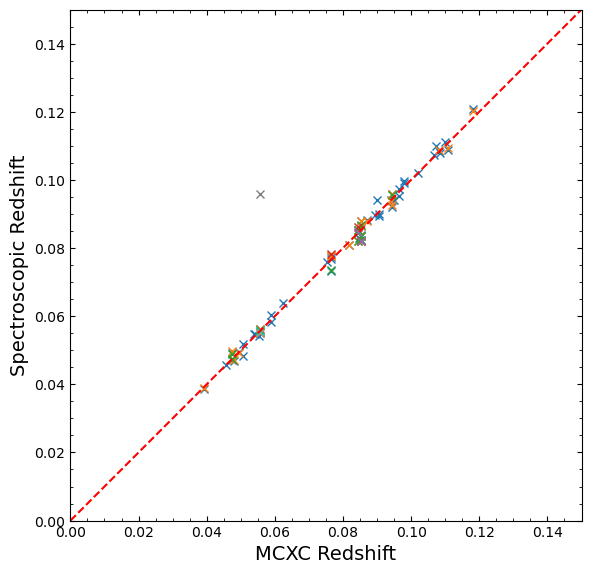

In [55]:
lims = [0, 0.15]

plt.figure(figsize=(6, 6))
plt.gca().set_aspect(1)
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)

og_zs = samp.loc[spec_info.index]['redshift'].values

plt.plot(og_zs, bcg1_all_spec_zs, 'x', label=['spec-{}'.format(ind) for ind in range(bcg1_all_spec_zs.shape[1])])

plt.plot(lims, lims, color='red', linestyle='dashed')
plt.xlim(lims)
plt.ylim(lims)

plt.ylabel("Spectroscopic Redshift", fontsize=14)
plt.xlabel("MCXC Redshift", fontsize=14)

# plt.legend()
plt.tight_layout()
plt.show()

In [74]:
np.where((bcg1_all_spec_zs.values / og_zs[..., None] > 3))

(array([2, 2, 2]), array([3, 5, 6]))

In [83]:
spec_info.iloc[2].loc(axis=0)['BCG1', :, 'z']

BCG1  spec0  z    0.055359
      spec1  z    0.055158
      spec2  z    0.055488
      spec3  z    0.330414
      spec4  z    0.055128
      spec5  z    0.327754
      spec6  z    0.328707
      spec7  z    0.095876
      spec8  z    0.055441
      spec9  z    0.055589
Name: LoVoCCS-4A, dtype: object

### BCG2 redshifts compared to MCXC

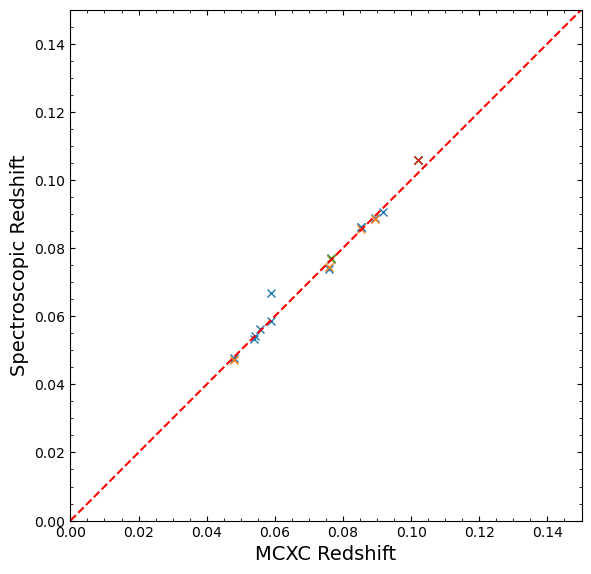

In [60]:
lims = [0, 0.15]

plt.figure(figsize=(6, 6))
plt.gca().set_aspect(1)
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)

og_zs = samp.loc[spec_info.index]['redshift'].values

plt.plot(og_zs, bcg2_all_spec_zs, 'x', label=['spec-{}'.format(ind) for ind in range(bcg2_all_spec_zs.shape[1])])

plt.plot(lims, lims, color='red', linestyle='dashed')
plt.xlim(lims)
plt.ylim(lims)

plt.ylabel("Spectroscopic Redshift", fontsize=14)
plt.xlabel("MCXC Redshift", fontsize=14)

# plt.legend()
plt.tight_layout()
plt.show()

### BCG3 redshifts compared to MCXC

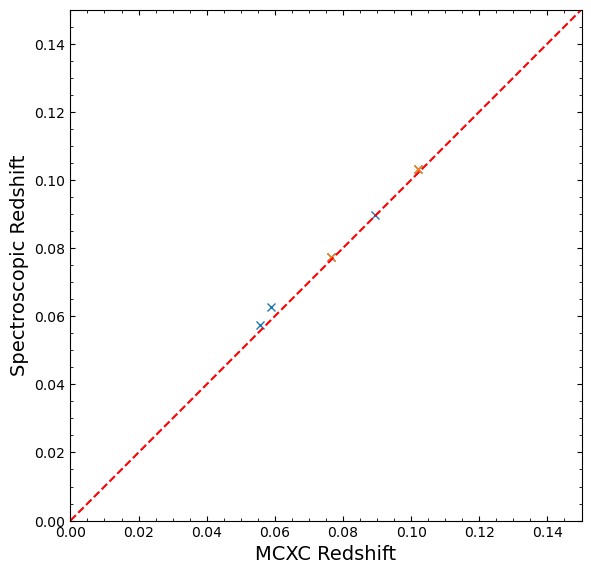

In [62]:
lims = [0, 0.15]

plt.figure(figsize=(6, 6))
plt.gca().set_aspect(1)
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)

og_zs = samp.loc[spec_info.index]['redshift'].values

plt.plot(og_zs, bcg3_all_spec_zs, 'x', label=['spec-{}'.format(ind) for ind in range(bcg3_all_spec_zs.shape[1])])

plt.plot(lims, lims, color='red', linestyle='dashed')
plt.xlim(lims)
plt.ylim(lims)

plt.ylabel("Spectroscopic Redshift", fontsize=14)
plt.xlabel("MCXC Redshift", fontsize=14)

# plt.legend()
plt.tight_layout()
plt.show()